# XGBoost con variables de las diferencias de medias ponderadas

* [Carga de los datos](#carga-de-los-datos)
* [Transformaciones](#transformaciones)
* [Selección de variables](#seleccion-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparametros)
* [Conclusiones](#conclusiones)

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import mlflow
import optuna
from optuna.samplers import TPESampler
import random

In [44]:
np.random.seed(42)
random.seed(42)

### Descripción general del notebook

En este notebook se llevará a cabo el modelado y entrenamiento de un modelo XGBoost con el propósito de predecir el ganador de una pelea. Para ello, se utilizarán las diferencias en las estadísticas medias de cada peleador como variables predictoras.

El objetivo principal es explorar alternativas que permitan mejorar el desempeño del modelo en comparación con la versión basada en medias ponderadas.

Dado que el proceso de transformación de datos, selección de variables y ajuste de hiperparámetros será similar al realizado en el otro notebook, estos aspectos no serán abordados en detalle en esta ocasión.

In [30]:
ruta_mlflow = os.path.abspath(os.path.join("..", "..", "..", "mlruns"))

 # Configurar MLflow para guardar los modelos en esa ruta
mlflow.set_tracking_uri(f"file:///{ruta_mlflow}")

print("MLflow tracking URI:", mlflow.get_tracking_uri())  

MLflow tracking URI: file:///c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\mlruns


In [31]:
mlflow.set_experiment("Prueba con df ponderado P2 usanod P2_dif XGBoost, datos finales")

2025/03/26 11:07:03 INFO mlflow.tracking.fluent: Experiment with name 'Prueba con df ponderado P2 usanod P2_dif XGBoost, datos finales' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:\\Users\\mattu\\OneDrive\\Documentos\\GitHub\\c2425-R4\\mlruns/327375263980051994', creation_time=1742983623731, experiment_id='327375263980051994', last_update_time=1742983623731, lifecycle_stage='active', name='Prueba con df ponderado P2 usanod P2_dif XGBoost, datos finales', tags={}>

Para guardar los resultados de diferentes experimentos creamos un directorio mlruns donde se guardarán los modelos realizados con una breve descripción y sus resultados.

### Carga de los datos

Cargamos el conjunto de train y test los cuales han sido seleccionados respetando el orden cronológico debido a que es una serie temporal. Separamos los conjuntos en X e y. En X guardamos todas las variables que puedan ser introducidas al modelo, excluyendo los nombres, la fecha y la variable respuesta. En y guardamos la variable respuesta.

In [3]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..","..", "data", "P2_dif","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2010-01-02,Rashad Evans,Thiago Silva,False,0.04,-0.2808,0.193548,-0.40,0.00,-18.84,...,16.0,4,-8.396724,-1,-0.76,0.00,4.00,-0.24,0.0,1.0
1,2010-01-02,Sam Stout,Joe Lauzon,False,0.36,-0.2228,-0.371306,-2.72,0.00,-101.68,...,-3.0,1,-8.453158,-1,-1.60,-2.36,2.36,-1.00,1.0,2.6
2,2010-01-11,Rafael Dos Anjos,Kyle Bradley,False,0.00,0.0416,0.086912,1.52,0.24,213.96,...,0.0,0,-9.999989,0,-0.36,0.00,0.36,-0.60,0.0,0.6
3,2010-01-11,Amir Sadollah,Brad Blackburn,False,-1.84,-0.0176,0.000000,0.44,0.00,23.04,...,-4.0,0,-1.547747,-2,-1.00,1.00,-0.60,0.60,0.0,0.0
4,2010-01-11,Gray Maynard,Nate Diaz,False,0.00,0.0492,0.328320,-0.52,-0.48,249.72,...,-1.0,-1,-2.953928,5,1.00,-4.36,2.96,0.00,0.0,-1.6


In [4]:
ruta_test = os.path.join("..","..","..","data", "P2_dif","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2022-11-19,Kennedy Nzechukwu,Ion Cutelaba,False,-0.4,-0.1032,-0.110729,0.36,0.00,-39.60,...,-1.0,-6,86.483419,1,-0.64,0.00,-1.0,-1.00,-1.96,-1.40
1,2022-11-19,Vince Morales,Miles Johns,True,-0.4,-0.0820,0.153846,0.00,0.36,-52.16,...,0.0,2,14.457185,0,-1.00,0.00,1.0,0.00,-0.36,2.36
2,2022-11-19,Andre Fialho,Muslim Salikhov,True,0.4,0.0696,-0.192661,0.00,0.00,-54.80,...,-4.0,-3,-62.740928,0,-0.40,0.00,-2.6,0.00,-1.00,1.00
3,2022-11-19,Jennifer Maia,Maryna Moroz,False,0.0,-0.1640,-0.069020,-1.08,0.00,-340.04,...,2.0,0,-22.321428,-3,0.00,-0.36,-0.6,0.00,0.00,0.96
4,2022-12-03,Eryk Anders,Kyle Daukaus,False,0.0,-0.1396,-0.158176,-1.68,0.40,189.72,...,-1.0,8,-58.874428,0,3.00,-0.60,2.0,0.64,0.60,2.36


In [5]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.56343
True     0.43657
Name: proportion, dtype: float64

In [6]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.546166
True     0.453834
Name: proportion, dtype: float64

### Transformaciones

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización. Como no tenemos variables categóricas, tampoco será necesario ningún tipo de codificación.

### Seleccion de variables

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. 

### Ajuste de hiperparametros

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

### GridSearch

In [38]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)


    param_grid = {
    'n_estimators': [100, 250],
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [10,35,50],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}


    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_,grid_search.best_params_

#### Entrenamiento usando ajuste de hiperparámetros

In [39]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid,best_params = train_xgboost_grid(X_train,y_train,X_test,y_test)


-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 0.1, 'scale_pos_weight': np.float64(1.2905829596412555), 'subsample': 0.7}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.63      0.62      0.63       349
        True       0.56      0.57      0.56       290

    accuracy                           0.60       639
   macro avg       0.60      0.60      0.60       639
weighted avg       0.60      0.60      0.60       639



#### Predicción con el conjunto de test

In [40]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_test)
y_val_prob = best_grid.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5978090766823161
F1-Score: 0.5622
AUC-ROC: 0.6145
Precisión: 0.5556
Sensibilidad: 0.5690
Log-loss: 0.6751273207081139


Los resultados obtenidos con el modelo XGBoost, tras el ajuste de hiperparámetros, no son óptimos. Las métricas indican que el modelo no logra una mejora significativa en comparación con una predicción aleatoria y, además, su rendimiento es inferior al del modelo basado en medias ponderadas.

In [41]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="GridSearchCV"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_score(y_test, y_val_pred))

    print("Modelo guardado en MLflow")

Modelo guardado en MLflow


Esta celda la utilizamos para guardar el modelo y poder saber cual fue el que mejor nos funcionó cuando los comparemos.

#### Matriz de confusión

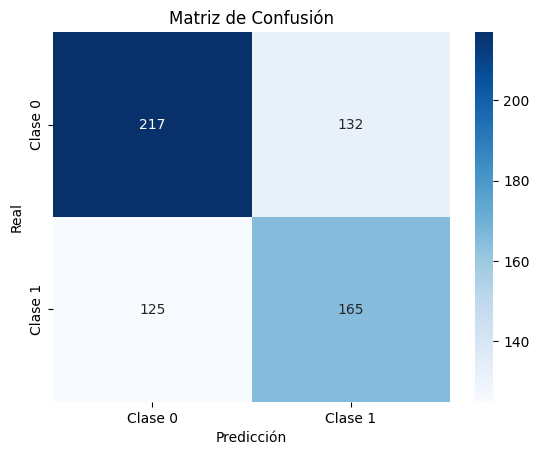

In [14]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Si nos fijamos en la matriz de confusión, hay un gran número de falsos positivos y falsos negativos. Por lo que  el modelo no llega a clasificar de forma adecuada cada observación.

#### Importancia de cada variable

Se observa que la variable con mayor peso en la predicción es Racha_DIFF, lo que sugiere que la diferencia en las rachas de victorias entre ambos peleadores es un factor determinante al momento de predecir el ganador de la pelea. 

Por otro lado, variables como STR_GROUND_A_DIFF (diferencia en golpes significativos en el suelo) y Puntos_DIFF (diferencia en los puntos obtenidos) presentan una importancia similar y considerable.

In [15]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
20               Racha_DIFF    0.068097
19              Puntos_DIFF    0.049397
26   Derrotas_Decision_DIFF    0.043937
14        STR_GROUND_A_DIFF    0.043822
24         Derrotas_KO_DIFF    0.041641
18              Peleas_DIFF    0.040595
9           STR_HEAD_A_DIFF    0.039352
4                  REV_DIFF    0.037963
5                 CTRL_DIFF    0.036412
2                   TD_DIFF    0.035998
7          TOTAL_STR_A_DIFF    0.035964
15             STRIKER_DIFF    0.035457
16            GRAPPLER_DIFF    0.035342
3              SUB_ATT_DIFF    0.035179
13        STR_CLINCH_A_DIFF    0.034963
11           STR_LEG_A_DIFF    0.034853
8                 TD_A_DIFF    0.033779
25        Derrotas_Sub_DIFF    0.033431
10          STR_BODY_A_DIFF    0.032885
12      STR_DISTANCE_A_DIFF    0.032566
21        Victorias_KO_DIFF    0.032154
6              TD_PORC_DIFF    0.032033
0                   KD_DIFF    0.031667
1              SIG_STR_DIFF    0.031413


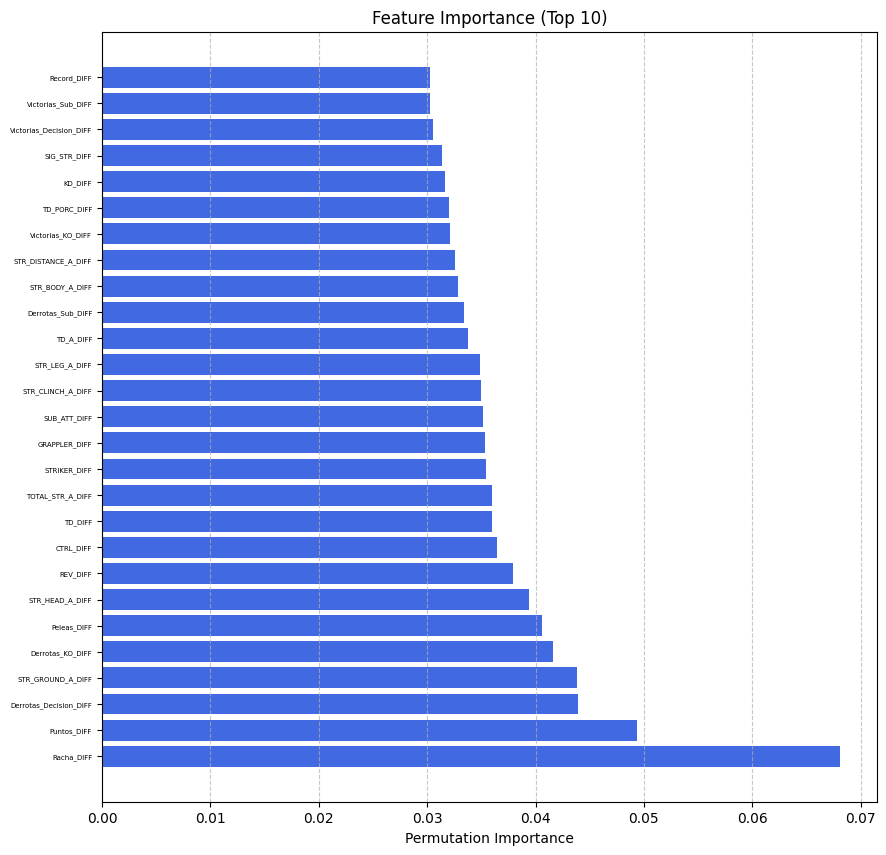

In [16]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### Random Search

In [34]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    """
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 60, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 70, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }"
    """
    
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 40, 2),
        'learning_rate': np.linspace(0.005, 0.2, 15),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 70, 2),
        'scale_pos_weight': [1, scale_pos_weight],
        'reg_alpha': [0, 0.1, 0.5, 1], #Parámetro regularización
        'tree_method': ['auto', 'exact', 'approx', 'hist'], #Método construcción árbol
        'grow_policy': ['depthwise', 'lossguide'] #Política crecimiento árbol
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))


    return random_search

#### Entrenamiento usando ajuste de hiperparámetros

In [35]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
resultados_random = train_xgboost_random(X_train,y_train,X_test,y_test)
best_random = resultados_random.best_estimator_
results_cv = resultados_random.cv_results_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits


Mejores parámetros: {'tree_method': 'exact', 'subsample': np.float64(0.6), 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'n_estimators': np.int64(250), 'min_child_weight': np.int64(9), 'max_depth': np.int64(13), 'learning_rate': np.float64(0.005), 'grow_policy': 'depthwise', 'gamma': np.float64(0.30000000000000004), 'colsample_bytree': np.float64(1.0)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.62      0.64      0.63       349
        True       0.55      0.53      0.54       290

    accuracy                           0.59       639
   macro avg       0.59      0.59      0.59       639
weighted avg       0.59      0.59      0.59       639



#### Predicción con el conjunto de test

In [36]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_test)
y_val_prob = best_random.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_test, y_val_pred))

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.593114241001565
F1-Score: 0.5423
AUC-ROC: 0.6084
Precisión: 0.5540
Sensibilidad: 0.5310
Log-loss: 0.6753232395007853
[[225 124]
 [136 154]]


In [37]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="RandomizedSearchCV"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_score(y_test, y_val_pred))

    print("Modelo guardado en MLflow")

Modelo guardado en MLflow


El modelo obtenido mediante Random Search ha mostrado un rendimiento inferior al modelo ajustado con Grid Search. En particular, el accuracy obtenido es menor que el de una estrategia trivial que siempre predice la clase mayoritaria, la cual alcanzaría un 54.61% de accuracy.

#### Matriz de confusión

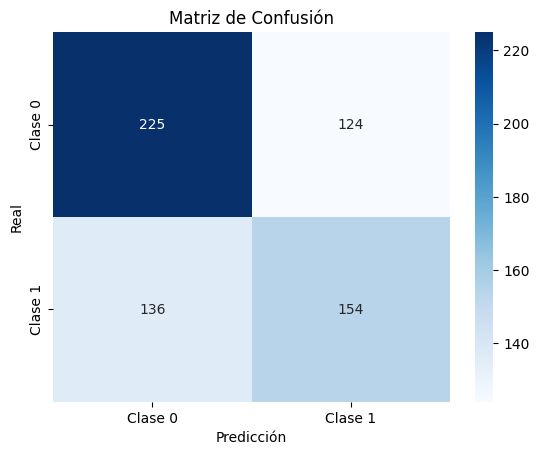

In [20]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Ocurre algo similar al modelo con GridSearh, donde hay un gran número de falsos positivos y negativos.

#### Importancia de cada variable

In [21]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
20               Racha_DIFF    0.063990
19              Puntos_DIFF    0.045405
24         Derrotas_KO_DIFF    0.039783
4                  REV_DIFF    0.039591
18              Peleas_DIFF    0.039157
9           STR_HEAD_A_DIFF    0.038980
26   Derrotas_Decision_DIFF    0.038872
14        STR_GROUND_A_DIFF    0.038680
5                 CTRL_DIFF    0.037453
3              SUB_ATT_DIFF    0.036817
7          TOTAL_STR_A_DIFF    0.036722
2                   TD_DIFF    0.036331
25        Derrotas_Sub_DIFF    0.035709
8                 TD_A_DIFF    0.035542
15             STRIKER_DIFF    0.035401
10          STR_BODY_A_DIFF    0.035358
16            GRAPPLER_DIFF    0.034869
12      STR_DISTANCE_A_DIFF    0.034826
13        STR_CLINCH_A_DIFF    0.034806
11           STR_LEG_A_DIFF    0.034433
21        Victorias_KO_DIFF    0.034414
1              SIG_STR_DIFF    0.034163
0                   KD_DIFF    0.033996
6              TD_PORC_DIFF    0.032400


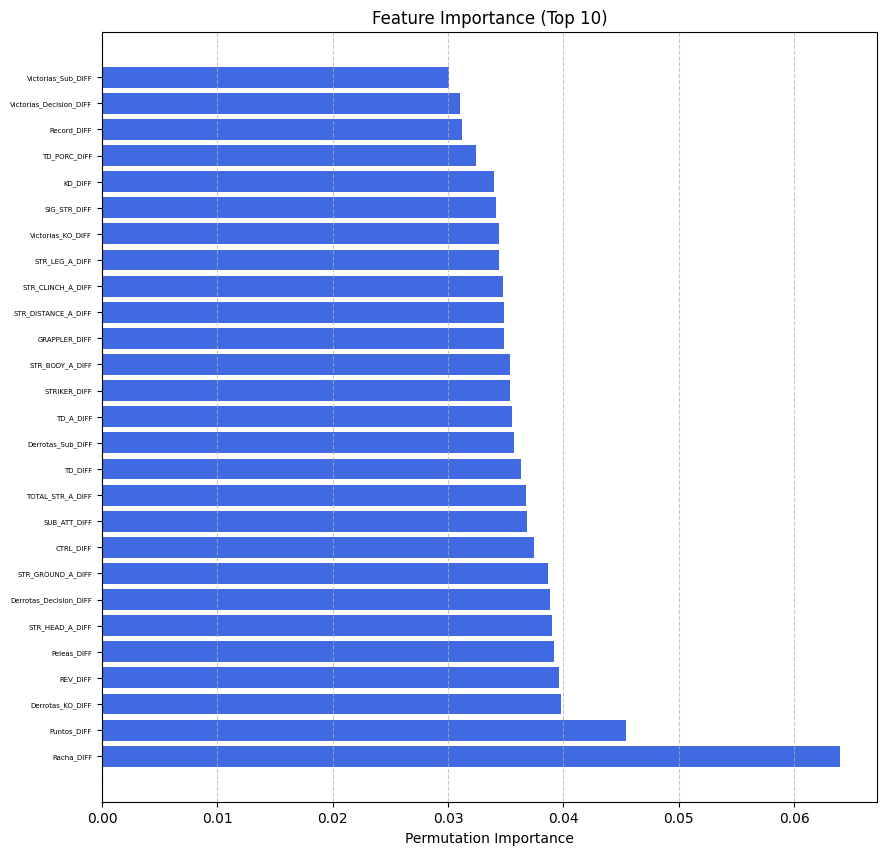

In [22]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### Optuna

In [ ]:

def objective(trial, X_train, y_train):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
    'max_depth': trial.suggest_int('max_depth', 3, 49, step=2),  # Ajustado de 40 a 39
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'gamma': trial.suggest_float('gamma', 0, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 69, step=2),  
    'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, scale_pos_weight]),
    'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5, 1]),
    'tree_method': trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),
    'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    'random_state': 42
}

    # Validación cruzada con series temporales
    tscv = TimeSeriesSplit(n_splits=5)
    model = XGBClassifier(**params)
    optuna.logging.set_verbosity(optuna.logging.INFO)
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='f1_macro', n_jobs=-1)
    return np.mean(scores)  # Retornamos el F1-score promedio


In [26]:
print("-- Entrenamiento usando ajuste de hiperparámetros con Optuna --")
best_acc = 0
best_seed = None
for i in range(1,25):
    sampler = TPESampler(seed=i)
    study = optuna.create_study(direction='maximize',sampler=sampler)
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)

    best_params = study.best_params
    best_model = XGBClassifier(**best_params)
    best_model.fit(X_train, y_train)
    y_val_pred = best_model.predict(X_test)
    y_val_prob = best_model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test,y_val_pred)
    print("Mejores parámetros:", best_params)
    print(f"aCC ACT: {acc}")
    if best_acc < acc:
        best_acc = acc
        best_seed = i
    print(f"MEJOR ACCURACY {best_acc} - {best_seed}")

[I 2025-03-26 10:57:22,006] A new study created in memory with name: no-name-b60db260-8f5f-47c3-a019-6f99ce426b8b


-- Entrenamiento usando ajuste de hiperparámetros con Optuna --


[I 2025-03-26 10:57:23,750] Trial 0 finished with value: 0.4618154057034907 and parameters: {'n_estimators': 250, 'max_depth': 37, 'learning_rate': 0.0010006061777325433, 'subsample': 0.7209330290527359, 'colsample_bytree': 0.5733779454085566, 'gamma': 0.0923385947687978, 'min_child_weight': 13, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4618154057034907.
[I 2025-03-26 10:57:24,785] Trial 1 finished with value: 0.48636628979319535 and parameters: {'n_estimators': 150, 'max_depth': 41, 'learning_rate': 0.16904367643810508, 'subsample': 0.7253696712636971, 'colsample_bytree': 0.846161307834657, 'gamma': 0.8763891522960383, 'min_child_weight': 63, 'scale_pos_weight': 1, 'reg_alpha': 0.1, 'tree_method': 'auto', 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.48636628979319535.
[I 2025-03-26 10:57:25,710] Trial 2 finished with value: 0.5051463861197153 and parameters: {'n_

Mejores parámetros: {'n_estimators': 500, 'max_depth': 29, 'learning_rate': 0.007494044036970185, 'subsample': 0.8203792876471587, 'colsample_bytree': 0.8726672154532511, 'gamma': 0.6692328934531846, 'min_child_weight': 19, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'exact', 'grow_policy': 'lossguide'}
aCC ACT: 0.5899843505477308
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:57:32,165] Trial 1 finished with value: 0.3581489377629863 and parameters: {'n_estimators': 100, 'max_depth': 27, 'learning_rate': 0.001413273464979454, 'subsample': 0.7712489310389558, 'colsample_bytree': 0.5482654578303063, 'gamma': 0.12715997170127746, 'min_child_weight': 41, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5012223568696854.
[I 2025-03-26 10:57:32,704] Trial 2 finished with value: 0.520082306718159 and parameters: {'n_estimators': 150, 'max_depth': 35, 'learning_rate': 0.16575283592282394, 'subsample': 0.8000033444680867, 'colsample_bytree': 0.9447600319730725, 'gamma': 0.34161365267110966, 'min_child_weight': 39, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.520082306718159.
[I 2025-03-26 10:57:32,888] Trial 3 finished with value: 0.5105002479030175 and parameters: {'n_

Mejores parámetros: {'n_estimators': 150, 'max_depth': 35, 'learning_rate': 0.16575283592282394, 'subsample': 0.8000033444680867, 'colsample_bytree': 0.9447600319730725, 'gamma': 0.34161365267110966, 'min_child_weight': 39, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'lossguide'}
aCC ACT: 0.5477308294209703
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:57:36,791] Trial 0 finished with value: 0.47084331527784806 and parameters: {'n_estimators': 300, 'max_depth': 35, 'learning_rate': 0.004670684478411477, 'subsample': 0.8043310420790653, 'colsample_bytree': 0.9464734771738273, 'gamma': 0.8962930889334381, 'min_child_weight': 9, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'exact', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.47084331527784806.
[I 2025-03-26 10:57:36,920] Trial 1 finished with value: 0.4802969264418122 and parameters: {'n_estimators': 250, 'max_depth': 15, 'learning_rate': 0.03934876817332707, 'subsample': 0.7761814870682958, 'colsample_bytree': 0.5784338692374816, 'gamma': 0.5446490180318447, 'min_child_weight': 55, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.4802969264418122.
[I 2025-03-26 10:57:37,468] Trial 2 finished with value: 0.459989191104469 and parameters: {'n_estimators': 250, 'max_depth': 1

Mejores parámetros: {'n_estimators': 400, 'max_depth': 35, 'learning_rate': 0.038532288605261665, 'subsample': 0.7494400496595713, 'colsample_bytree': 0.8340674023676338, 'gamma': 0.3398486639568179, 'min_child_weight': 41, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'depthwise'}
aCC ACT: 0.5696400625978091
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:57:44,136] Trial 0 finished with value: 0.4878453571193358 and parameters: {'n_estimators': 500, 'max_depth': 29, 'learning_rate': 0.17305170740456174, 'subsample': 0.8859263974697458, 'colsample_bytree': 0.8488644122986354, 'gamma': 0.21608949558037638, 'min_child_weight': 69, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4878453571193358.
[I 2025-03-26 10:57:44,631] Trial 1 finished with value: 0.5092778419308643 and parameters: {'n_estimators': 500, 'max_depth': 23, 'learning_rate': 0.15262484929049822, 'subsample': 0.9145223943740244, 'colsample_bytree': 0.9331446492908493, 'gamma': 0.17316542149594816, 'min_child_weight': 5, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'hist', 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.5092778419308643.
[I 2025-03-26 10:57:45,475] Trial 2 finished with value: 0.544831798999907 and parameters: {'n_estimat

Mejores parámetros: {'n_estimators': 250, 'max_depth': 41, 'learning_rate': 0.0090994423647208, 'subsample': 0.9618670354973468, 'colsample_bytree': 0.702412608655453, 'gamma': 0.33117450309112273, 'min_child_weight': 41, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'exact', 'grow_policy': 'lossguide'}
aCC ACT: 0.5852895148669797
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:57:50,725] Trial 0 finished with value: 0.3581489377629863 and parameters: {'n_estimators': 150, 'max_depth': 43, 'learning_rate': 0.00298997100709855, 'subsample': 0.9674443631751686, 'colsample_bytree': 0.7442055943974146, 'gamma': 0.6117438629026457, 'min_child_weight': 53, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'exact', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.3581489377629863.
[I 2025-03-26 10:57:51,915] Trial 1 finished with value: 0.5321632765671388 and parameters: {'n_estimators': 350, 'max_depth': 31, 'learning_rate': 0.004089382770461855, 'subsample': 0.7138743522565455, 'colsample_bytree': 0.6267941028868937, 'gamma': 0.3275639476887341, 'min_child_weight': 11, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0, 'tree_method': 'exact', 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.5321632765671388.
[I 2025-03-26 10:57:56,646] Trial 2 finished with value: 0.5092812857882462 and parameters: {'n_es

Mejores parámetros: {'n_estimators': 350, 'max_depth': 31, 'learning_rate': 0.004089382770461855, 'subsample': 0.7138743522565455, 'colsample_bytree': 0.6267941028868937, 'gamma': 0.3275639476887341, 'min_child_weight': 11, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0, 'tree_method': 'exact', 'grow_policy': 'lossguide'}
aCC ACT: 0.5774647887323944
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:58:04,579] Trial 0 finished with value: 0.48657672364498783 and parameters: {'n_estimators': 500, 'max_depth': 17, 'learning_rate': 0.0775662588976146, 'subsample': 0.6166786502900999, 'colsample_bytree': 0.553828339967984, 'gamma': 0.5950520642062402, 'min_child_weight': 37, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.48657672364498783.
[I 2025-03-26 10:58:04,876] Trial 1 finished with value: 0.5195087223147542 and parameters: {'n_estimators': 450, 'max_depth': 5, 'learning_rate': 0.04504077320402558, 'subsample': 0.9208682249697902, 'colsample_bytree': 0.8682033219057195, 'gamma': 0.7091317507811673, 'min_child_weight': 37, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'hist', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.5195087223147542.
[I 2025-03-26 10:58:05,707] Trial 2 finished with value: 0.5231772395161965 and parameters: {'n_esti

Mejores parámetros: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.0069627027961741, 'subsample': 0.6800374020456881, 'colsample_bytree': 0.8832407068378352, 'gamma': 0.9341811650828181, 'min_child_weight': 1, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'hist', 'grow_policy': 'depthwise'}
aCC ACT: 0.5868544600938967
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:58:09,869] Trial 0 finished with value: 0.5288763801746181 and parameters: {'n_estimators': 100, 'max_depth': 39, 'learning_rate': 0.010204524951330765, 'subsample': 0.8893860711323764, 'colsample_bytree': 0.9889947559983013, 'gamma': 0.5384958704104337, 'min_child_weight': 35, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5288763801746181.
[I 2025-03-26 10:58:10,040] Trial 1 finished with value: 0.5089553832693612 and parameters: {'n_estimators': 100, 'max_depth': 31, 'learning_rate': 0.15355942605193532, 'subsample': 0.6921211516083859, 'colsample_bytree': 0.7742449596180152, 'gamma': 0.9091283748867313, 'min_child_weight': 9, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0, 'tree_method': 'hist', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5288763801746181.
[I 2025-03-26 10:58:10,858] Trial 2 finished with value: 0.49099634242

Mejores parámetros: {'n_estimators': 100, 'max_depth': 39, 'learning_rate': 0.010204524951330765, 'subsample': 0.8893860711323764, 'colsample_bytree': 0.9889947559983013, 'gamma': 0.5384958704104337, 'min_child_weight': 35, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'lossguide'}
aCC ACT: 0.5899843505477308
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:58:17,295] Trial 0 finished with value: 0.5099821756227729 and parameters: {'n_estimators': 450, 'max_depth': 49, 'learning_rate': 0.10000983461717242, 'subsample': 0.8123422766222396, 'colsample_bytree': 0.6163641639886454, 'gamma': 0.011398804277429897, 'min_child_weight': 31, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5099821756227729.
[I 2025-03-26 10:58:17,810] Trial 1 finished with value: 0.507303681925908 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.18264786896754368, 'subsample': 0.6511422851700127, 'colsample_bytree': 0.6610653966020896, 'gamma': 0.07094284475019874, 'min_child_weight': 15, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5099821756227729.
[I 2025-03-26 10:58:18,199] Trial 2 finished with value: 0.5209115081

Mejores parámetros: {'n_estimators': 500, 'max_depth': 45, 'learning_rate': 0.0031608899689920676, 'subsample': 0.8421510005250468, 'colsample_bytree': 0.7359765602679645, 'gamma': 0.3591089147932802, 'min_child_weight': 37, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'approx', 'grow_policy': 'lossguide'}
aCC ACT: 0.5837245696400626
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:58:25,360] Trial 1 finished with value: 0.4863022782331486 and parameters: {'n_estimators': 400, 'max_depth': 21, 'learning_rate': 0.039620890078514985, 'subsample': 0.9299481858002192, 'colsample_bytree': 0.732834237683633, 'gamma': 0.9405244095266561, 'min_child_weight': 57, 'scale_pos_weight': 1, 'reg_alpha': 0.1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.4863022782331486.
[I 2025-03-26 10:58:25,510] Trial 2 finished with value: 0.5050579744003889 and parameters: {'n_estimators': 250, 'max_depth': 25, 'learning_rate': 0.02540186801628888, 'subsample': 0.7985126870684748, 'colsample_bytree': 0.7389870067691735, 'gamma': 0.43555546476634577, 'min_child_weight': 61, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'auto', 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.5050579744003889.
[I 2025-03-26 10:58:25,703] Trial 3 finished with value: 0.41582554876454403 and parameters: {'n_e

Mejores parámetros: {'n_estimators': 400, 'max_depth': 37, 'learning_rate': 0.11402210870375447, 'subsample': 0.8866596349573894, 'colsample_bytree': 0.8410763850857014, 'gamma': 0.8431168420521119, 'min_child_weight': 45, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'exact', 'grow_policy': 'depthwise'}
aCC ACT: 0.564945226917058
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:58:40,652] Trial 0 finished with value: 0.519372167334334 and parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.0287106877063144, 'subsample': 0.8995215530154448, 'colsample_bytree': 0.7492535061512953, 'gamma': 0.22479664553084766, 'min_child_weight': 13, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'exact', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.519372167334334.
[I 2025-03-26 10:58:40,938] Trial 1 finished with value: 0.39013371438547345 and parameters: {'n_estimators': 400, 'max_depth': 29, 'learning_rate': 0.0021239170144570336, 'subsample': 0.7493363040205877, 'colsample_bytree': 0.8370668075331726, 'gamma': 0.4418331744229961, 'min_child_weight': 31, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'auto', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.519372167334334.
[I 2025-03-26 10:58:41,228] Trial 2 finished with value: 0.4673171508713603 and parameters: {'n_estimators': 100, 'max_depth': 3

Mejores parámetros: {'n_estimators': 300, 'max_depth': 41, 'learning_rate': 0.003788082448408252, 'subsample': 0.8389486592923537, 'colsample_bytree': 0.9514158801658137, 'gamma': 0.5345579488018151, 'min_child_weight': 41, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'hist', 'grow_policy': 'depthwise'}
aCC ACT: 0.5821596244131455
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:58:44,969] Trial 1 finished with value: 0.5140878267239104 and parameters: {'n_estimators': 150, 'max_depth': 39, 'learning_rate': 0.07636179756093606, 'subsample': 0.737849796383687, 'colsample_bytree': 0.6593993984312168, 'gamma': 0.11166123199466038, 'min_child_weight': 5, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'hist', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5462821042946344.
[I 2025-03-26 10:58:45,577] Trial 2 finished with value: 0.47244662199408954 and parameters: {'n_estimators': 200, 'max_depth': 41, 'learning_rate': 0.0014013428033520952, 'subsample': 0.7458462571984165, 'colsample_bytree': 0.5350114013122512, 'gamma': 0.31936770705091, 'min_child_weight': 5, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0, 'tree_method': 'hist', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5462821042946344.
[I 2025-03-26 10:58:47,252] Trial 3 finished with value: 0.5104100475240836 and parameters: {'n_estimato

Mejores parámetros: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.011638036743766822, 'subsample': 0.8899735716768591, 'colsample_bytree': 0.7101018022938637, 'gamma': 0.4854270981677824, 'min_child_weight': 1, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'auto', 'grow_policy': 'lossguide'}
aCC ACT: 0.5758998435054773
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:58:51,350] Trial 1 finished with value: 0.4284382914612997 and parameters: {'n_estimators': 150, 'max_depth': 39, 'learning_rate': 0.0011165648946363195, 'subsample': 0.6540840713476467, 'colsample_bytree': 0.558136508700845, 'gamma': 0.30989758449002924, 'min_child_weight': 47, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'exact', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.47653442455201966.
[I 2025-03-26 10:58:51,583] Trial 2 finished with value: 0.5348950774842605 and parameters: {'n_estimators': 250, 'max_depth': 23, 'learning_rate': 0.00835344065797477, 'subsample': 0.9980552641354234, 'colsample_bytree': 0.5887820879689447, 'gamma': 0.9625969030278503, 'min_child_weight': 29, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.5348950774842605.
[I 2025-03-26 10:58:51,974] Trial 3 finished with value: 0.3581489

Mejores parámetros: {'n_estimators': 150, 'max_depth': 37, 'learning_rate': 0.02992196827637318, 'subsample': 0.7192924116926547, 'colsample_bytree': 0.68791394765973, 'gamma': 0.9886278651751473, 'min_child_weight': 25, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'auto', 'grow_policy': 'lossguide'}
aCC ACT: 0.5868544600938967
MEJOR ACCURACY 0.5899843505477308 - 1


[I 2025-03-26 10:58:53,598] Trial 0 finished with value: 0.5046566522127679 and parameters: {'n_estimators': 400, 'max_depth': 13, 'learning_rate': 0.07882965546640572, 'subsample': 0.9862996792171999, 'colsample_bytree': 0.9863005569524467, 'gamma': 0.4534492474173122, 'min_child_weight': 43, 'scale_pos_weight': 1, 'reg_alpha': 0, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5046566522127679.
[I 2025-03-26 10:58:54,584] Trial 1 finished with value: 0.527795672331606 and parameters: {'n_estimators': 250, 'max_depth': 47, 'learning_rate': 0.0031724307883199826, 'subsample': 0.7277565465521458, 'colsample_bytree': 0.9588861930002937, 'gamma': 0.03190366643989473, 'min_child_weight': 5, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'hist', 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.527795672331606.
[I 2025-03-26 10:58:54,962] Trial 2 finished with value: 0.5389778035882454 and parameters: {'n_estim

Mejores parámetros: {'n_estimators': 400, 'max_depth': 17, 'learning_rate': 0.004338872863446674, 'subsample': 0.8781781810213898, 'colsample_bytree': 0.9592758740729743, 'gamma': 0.2444757021979903, 'min_child_weight': 33, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'auto', 'grow_policy': 'lossguide'}
aCC ACT: 0.594679186228482
MEJOR ACCURACY 0.594679186228482 - 13


[I 2025-03-26 10:59:00,284] Trial 0 finished with value: 0.5166948209670548 and parameters: {'n_estimators': 300, 'max_depth': 39, 'learning_rate': 0.1006653977605827, 'subsample': 0.6032187794119271, 'colsample_bytree': 0.6548679627526021, 'gamma': 0.9576037393658909, 'min_child_weight': 35, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'hist', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5166948209670548.
[I 2025-03-26 10:59:00,704] Trial 1 finished with value: 0.38252603835620097 and parameters: {'n_estimators': 400, 'max_depth': 43, 'learning_rate': 0.001792128407592232, 'subsample': 0.7200367921575135, 'colsample_bytree': 0.7374528829752343, 'gamma': 0.6729367191665858, 'min_child_weight': 19, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'auto', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5166948209670548.
[I 2025-03-26 10:59:00,987] Trial 2 finished with value: 0.4680392502229799 and parameters: {'n_es

Mejores parámetros: {'n_estimators': 400, 'max_depth': 33, 'learning_rate': 0.0016806607157262483, 'subsample': 0.8606344240291128, 'colsample_bytree': 0.9843080041756764, 'gamma': 0.23695196706301513, 'min_child_weight': 27, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0, 'tree_method': 'hist', 'grow_policy': 'lossguide'}
aCC ACT: 0.593114241001565
MEJOR ACCURACY 0.594679186228482 - 13


[I 2025-03-26 10:59:11,730] Trial 0 finished with value: 0.3651627192344825 and parameters: {'n_estimators': 450, 'max_depth': 11, 'learning_rate': 0.0013338020690522791, 'subsample': 0.7446153784352891, 'colsample_bytree': 0.637700464303206, 'gamma': 0.5300002248954253, 'min_child_weight': 21, 'scale_pos_weight': 1, 'reg_alpha': 0.1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.3651627192344825.
[I 2025-03-26 10:59:11,827] Trial 1 finished with value: 0.4925027173141824 and parameters: {'n_estimators': 150, 'max_depth': 49, 'learning_rate': 0.007207655472981398, 'subsample': 0.9042041095715798, 'colsample_bytree': 0.7367372213415806, 'gamma': 0.5097153058176547, 'min_child_weight': 67, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.4925027173141824.
[I 2025-03-26 10:59:22,217] Trial 2 finished with value: 0.3581489377629863 and parameters: {'n_e

Mejores parámetros: {'n_estimators': 300, 'max_depth': 35, 'learning_rate': 0.00740464015562866, 'subsample': 0.8865734221146688, 'colsample_bytree': 0.682509893699728, 'gamma': 0.551521872294001, 'min_child_weight': 41, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'approx', 'grow_policy': 'lossguide'}
aCC ACT: 0.5821596244131455
MEJOR ACCURACY 0.594679186228482 - 13


[I 2025-03-26 10:59:27,390] Trial 1 finished with value: 0.5196450076892206 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.129307981212731, 'subsample': 0.8265785314876782, 'colsample_bytree': 0.7360096578709636, 'gamma': 0.3145664246472115, 'min_child_weight': 3, 'scale_pos_weight': 1, 'reg_alpha': 0.1, 'tree_method': 'exact', 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.5196450076892206.
[I 2025-03-26 10:59:27,489] Trial 2 finished with value: 0.5087824417576704 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05953490393266979, 'subsample': 0.9264569305155398, 'colsample_bytree': 0.569820801874148, 'gamma': 0.5780067455748411, 'min_child_weight': 23, 'scale_pos_weight': 1, 'reg_alpha': 0.1, 'tree_method': 'hist', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.5196450076892206.
[I 2025-03-26 10:59:28,718] Trial 3 finished with value: 0.4864414675230053 and parameters: {'n_estimators': 400, 'max_depth': 49, 'l

Mejores parámetros: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.129307981212731, 'subsample': 0.8265785314876782, 'colsample_bytree': 0.7360096578709636, 'gamma': 0.3145664246472115, 'min_child_weight': 3, 'scale_pos_weight': 1, 'reg_alpha': 0.1, 'tree_method': 'exact', 'grow_policy': 'lossguide'}
aCC ACT: 0.5508607198748043
MEJOR ACCURACY 0.594679186228482 - 13


[I 2025-03-26 10:59:31,347] Trial 1 finished with value: 0.5146753273632794 and parameters: {'n_estimators': 200, 'max_depth': 17, 'learning_rate': 0.01959064947030921, 'subsample': 0.7584189744188106, 'colsample_bytree': 0.8943503548394498, 'gamma': 0.41848438534587695, 'min_child_weight': 11, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.5146753273632794.
[I 2025-03-26 10:59:31,528] Trial 2 finished with value: 0.49507096102634074 and parameters: {'n_estimators': 300, 'max_depth': 45, 'learning_rate': 0.06831828588241651, 'subsample': 0.6271914913054505, 'colsample_bytree': 0.9803938782333891, 'gamma': 0.6592053923760217, 'min_child_weight': 51, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'hist', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.5146753273632794.
[I 2025-03-26 10:59:32,084] Trial 3 finished with value: 0.5123632680722906 and parameters: {'n_est

Mejores parámetros: {'n_estimators': 350, 'max_depth': 37, 'learning_rate': 0.012723547483823972, 'subsample': 0.7350458670629506, 'colsample_bytree': 0.6948531446608657, 'gamma': 0.8587971938450034, 'min_child_weight': 35, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0, 'tree_method': 'exact', 'grow_policy': 'lossguide'}
aCC ACT: 0.5774647887323944
MEJOR ACCURACY 0.594679186228482 - 13


[I 2025-03-26 10:59:34,647] Trial 0 finished with value: 0.48332427247533716 and parameters: {'n_estimators': 350, 'max_depth': 27, 'learning_rate': 0.1051207229045272, 'subsample': 0.6727360901486138, 'colsample_bytree': 0.9261165343372986, 'gamma': 0.7501362861060107, 'min_child_weight': 47, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'hist', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.48332427247533716.
[I 2025-03-26 10:59:35,361] Trial 1 finished with value: 0.5061521963505641 and parameters: {'n_estimators': 350, 'max_depth': 35, 'learning_rate': 0.006469424380310367, 'subsample': 0.9159842191301226, 'colsample_bytree': 0.9070239690585242, 'gamma': 0.19742128450213303, 'min_child_weight': 67, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'exact', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.5061521963505641.
[I 2025-03-26 10:59:39,242] Trial 2 finished with value: 0.48797697449531474 and parameters: {'

Mejores parámetros: {'n_estimators': 500, 'max_depth': 43, 'learning_rate': 0.00604585559575491, 'subsample': 0.9252869353550648, 'colsample_bytree': 0.6899908339033354, 'gamma': 0.007713667317334472, 'min_child_weight': 7, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'exact', 'grow_policy': 'depthwise'}
aCC ACT: 0.5758998435054773
MEJOR ACCURACY 0.594679186228482 - 13


[I 2025-03-26 10:59:46,579] Trial 0 finished with value: 0.46877322890292483 and parameters: {'n_estimators': 100, 'max_depth': 39, 'learning_rate': 0.0037000848495103195, 'subsample': 0.6552526749905278, 'colsample_bytree': 0.6657232816354657, 'gamma': 0.08299956500689287, 'min_child_weight': 47, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.46877322890292483.
[I 2025-03-26 10:59:47,459] Trial 1 finished with value: 0.5124528897416274 and parameters: {'n_estimators': 400, 'max_depth': 19, 'learning_rate': 0.15036357546309015, 'subsample': 0.9109431672426828, 'colsample_bytree': 0.8040171515337272, 'gamma': 0.615232036586069, 'min_child_weight': 45, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'exact', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.5124528897416274.
[I 2025-03-26 10:59:47,691] Trial 2 finished with value: 0.484733

Mejores parámetros: {'n_estimators': 350, 'max_depth': 21, 'learning_rate': 0.0030004332986498343, 'subsample': 0.7519564787950488, 'colsample_bytree': 0.5918082072362678, 'gamma': 0.48636239703774564, 'min_child_weight': 5, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}
aCC ACT: 0.568075117370892
MEJOR ACCURACY 0.594679186228482 - 13


[I 2025-03-26 10:59:53,406] Trial 0 finished with value: 0.5160103738687039 and parameters: {'n_estimators': 350, 'max_depth': 45, 'learning_rate': 0.11257422105117798, 'subsample': 0.9263349909230736, 'colsample_bytree': 0.5179447928084266, 'gamma': 0.6917575817588839, 'min_child_weight': 27, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5160103738687039.
[I 2025-03-26 10:59:54,153] Trial 1 finished with value: 0.514506745529521 and parameters: {'n_estimators': 200, 'max_depth': 43, 'learning_rate': 0.15327454244349992, 'subsample': 0.8246747432044632, 'colsample_bytree': 0.5893902599249883, 'gamma': 0.7702519331384002, 'min_child_weight': 35, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5160103738687039.
[I 2025-03-26 10:59:55,312] Trial 2 finished with value: 0.497883051926

Mejores parámetros: {'n_estimators': 300, 'max_depth': 33, 'learning_rate': 0.004143284884909205, 'subsample': 0.8431068317673148, 'colsample_bytree': 0.52407868500731, 'gamma': 0.6955006394243272, 'min_child_weight': 21, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'approx', 'grow_policy': 'lossguide'}
aCC ACT: 0.593114241001565
MEJOR ACCURACY 0.594679186228482 - 13


[I 2025-03-26 11:00:04,638] Trial 0 finished with value: 0.5016071056902714 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.04560003646142163, 'subsample': 0.6086464999663799, 'colsample_bytree': 0.6029613826337195, 'gamma': 0.0507732566953768, 'min_child_weight': 21, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5016071056902714.
[I 2025-03-26 11:00:05,396] Trial 1 finished with value: 0.48492863578212286 and parameters: {'n_estimators': 250, 'max_depth': 21, 'learning_rate': 0.04379895434381183, 'subsample': 0.7082679090692535, 'colsample_bytree': 0.9270514359956721, 'gamma': 0.9131639696118056, 'min_child_weight': 53, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5016071056902714.
[I 2025-03-26 11:00:06,436] Trial 2 finished with value: 0.5012935149608756 and parameters: {'n_estimators': 350, 'max_depth'

Mejores parámetros: {'n_estimators': 100, 'max_depth': 39, 'learning_rate': 0.013855267540212752, 'subsample': 0.7097002483532678, 'colsample_bytree': 0.9049166524337446, 'gamma': 0.3376761198544125, 'min_child_weight': 13, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'exact', 'grow_policy': 'lossguide'}
aCC ACT: 0.6025039123630673
MEJOR ACCURACY 0.6025039123630673 - 21


[I 2025-03-26 11:00:12,889] Trial 1 finished with value: 0.4835379367098452 and parameters: {'n_estimators': 200, 'max_depth': 39, 'learning_rate': 0.03833637187105349, 'subsample': 0.7548733921524089, 'colsample_bytree': 0.807602912546528, 'gamma': 0.42755523984434063, 'min_child_weight': 41, 'scale_pos_weight': 1, 'reg_alpha': 0.1, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.4835379367098452.
[I 2025-03-26 11:00:14,099] Trial 2 finished with value: 0.5267110144075621 and parameters: {'n_estimators': 300, 'max_depth': 27, 'learning_rate': 0.005202706504477802, 'subsample': 0.6182646170395162, 'colsample_bytree': 0.7188403300410497, 'gamma': 0.09588460991804115, 'min_child_weight': 3, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'hist', 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.5267110144075621.
[I 2025-03-26 11:00:14,624] Trial 3 finished with value: 0.5227401551602081 and parameters: {'n_

Mejores parámetros: {'n_estimators': 400, 'max_depth': 45, 'learning_rate': 0.004116016411834996, 'subsample': 0.8655277391995577, 'colsample_bytree': 0.7174935234754871, 'gamma': 0.5146685042108027, 'min_child_weight': 39, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}
aCC ACT: 0.5884194053208138
MEJOR ACCURACY 0.6025039123630673 - 21


[I 2025-03-26 11:00:20,837] Trial 0 finished with value: 0.5167365922631136 and parameters: {'n_estimators': 300, 'max_depth': 47, 'learning_rate': 0.05772259761433054, 'subsample': 0.7129583375868451, 'colsample_bytree': 0.6105226816308262, 'gamma': 0.6862220852374669, 'min_child_weight': 11, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'approx', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5167365922631136.
[I 2025-03-26 11:00:21,436] Trial 1 finished with value: 0.5036937118814376 and parameters: {'n_estimators': 200, 'max_depth': 41, 'learning_rate': 0.02759725923362189, 'subsample': 0.6441910855654694, 'colsample_bytree': 0.500264405584638, 'gamma': 0.9421662328554996, 'min_child_weight': 9, 'scale_pos_weight': 1, 'reg_alpha': 0, 'tree_method': 'exact', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5167365922631136.
[I 2025-03-26 11:00:23,461] Trial 2 finished with value: 0.5251944662227089 and parameters: {'n_estima

Mejores parámetros: {'n_estimators': 450, 'max_depth': 9, 'learning_rate': 0.003404992738376015, 'subsample': 0.967178322281572, 'colsample_bytree': 0.5645317638030853, 'gamma': 0.9164077220658395, 'min_child_weight': 17, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'lossguide'}
aCC ACT: 0.5852895148669797
MEJOR ACCURACY 0.6025039123630673 - 21


[I 2025-03-26 11:00:33,169] Trial 0 finished with value: 0.48878828546243086 and parameters: {'n_estimators': 500, 'max_depth': 35, 'learning_rate': 0.19985942426788925, 'subsample': 0.6880269199131407, 'colsample_bytree': 0.680528176982029, 'gamma': 0.739840990209437, 'min_child_weight': 69, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.48878828546243086.
[I 2025-03-26 11:00:33,422] Trial 1 finished with value: 0.44676725405175316 and parameters: {'n_estimators': 500, 'max_depth': 43, 'learning_rate': 0.005059925802794065, 'subsample': 0.8524679109820782, 'colsample_bytree': 0.8401194302230776, 'gamma': 0.9704275603953206, 'min_child_weight': 63, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'auto', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.48878828546243086.
[I 2025-03-26 11:00:34,478] Trial 2 finished with value: 0.5414109716333173 and parameters: {'n_estimators': 450, 'max_depth': 13

Mejores parámetros: {'n_estimators': 450, 'max_depth': 13, 'learning_rate': 0.00842396660974823, 'subsample': 0.8497500248639542, 'colsample_bytree': 0.571518352941951, 'gamma': 0.12279848359327927, 'min_child_weight': 29, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'exact', 'grow_policy': 'lossguide'}
aCC ACT: 0.5821596244131455
MEJOR ACCURACY 0.6025039123630673 - 21


In [29]:
sampler = TPESampler(seed=21)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)

best_params = study.best_params
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

[I 2025-03-26 11:06:24,767] A new study created in memory with name: no-name-e30d8652-4a50-42fd-8301-83c8860486de
[I 2025-03-26 11:06:26,629] Trial 0 finished with value: 0.5016071056902714 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.04560003646142163, 'subsample': 0.6086464999663799, 'colsample_bytree': 0.6029613826337195, 'gamma': 0.0507732566953768, 'min_child_weight': 21, 'scale_pos_weight': 1, 'reg_alpha': 0.5, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5016071056902714.
[I 2025-03-26 11:06:28,281] Trial 1 finished with value: 0.48492863578212286 and parameters: {'n_estimators': 250, 'max_depth': 21, 'learning_rate': 0.04379895434381183, 'subsample': 0.7082679090692535, 'colsample_bytree': 0.9270514359956721, 'gamma': 0.9131639696118056, 'min_child_weight': 53, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.5016071056902714.
[I 2025-03-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9049166524337446, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3376761198544125,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.013855267540212752,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=39, max_leaves=None,
              min_child_weight=13, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
y_val_pred = best_model.predict(X_test)
y_val_prob = best_model.predict_proba(X_test)[:,1]

print("-- Métricas del modelo con hiperparámetros ajustados --")
print("Accuracy:", accuracy_score(y_test, y_val_pred))
print(f"F1-Score: {f1_score(y_test, y_val_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_val_prob):.4f}")
print(f"Precisión: {precision_score(y_test, y_val_pred):.4f}")
print(f"Sensibilidad: {recall_score(y_test, y_val_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_val_prob):.4f}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.6025039123630673
F1-Score: 0.5606
AUC-ROC: 0.6118
Precisión: 0.5625
Sensibilidad: 0.5586
Log-loss: 0.6740


In [33]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="uso de Optuna para ajustar hiperparámetros n_trials=10, sampler seed=21"):

    # Guardar modelo en MLflow
    mlflow.xgboost.log_model(best_model, "modelo_xgboost")
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_score(y_test, y_val_pred))

    print("Modelo guardado en MLflow")

c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/26 11:07:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/26 11:07:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo guardado en MLflow


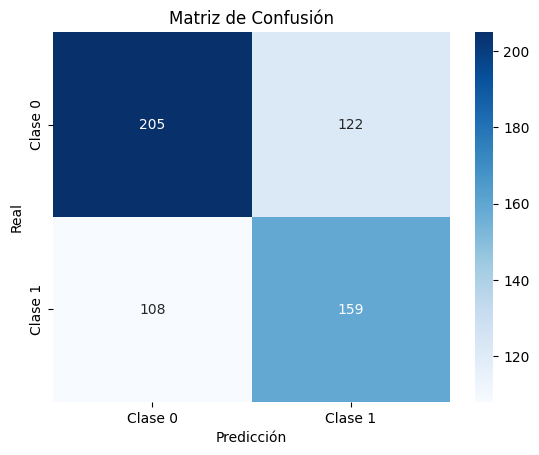

In [70]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [71]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
20               Racha_DIFF    0.064529
19              Puntos_DIFF    0.046249
16            GRAPPLER_DIFF    0.044933
26   Derrotas_Decision_DIFF    0.044815
6              TD_PORC_DIFF    0.044134
9           STR_HEAD_A_DIFF    0.043639
24         Derrotas_KO_DIFF    0.041263
18              Peleas_DIFF    0.041236
2                   TD_DIFF    0.039759
14        STR_GROUND_A_DIFF    0.038292
10          STR_BODY_A_DIFF    0.037763
23  Victorias_Decision_DIFF    0.034853
25        Derrotas_Sub_DIFF    0.033828
11           STR_LEG_A_DIFF    0.033803
7          TOTAL_STR_A_DIFF    0.033390
5                 CTRL_DIFF    0.033142
13        STR_CLINCH_A_DIFF    0.032594
8                 TD_A_DIFF    0.032587
22       Victorias_Sub_DIFF    0.032437
21        Victorias_KO_DIFF    0.032336
1              SIG_STR_DIFF    0.032185
17              Record_DIFF    0.031114
3              SUB_ATT_DIFF    0.031101
12      STR_DISTANCE_A_DIFF    0.030802


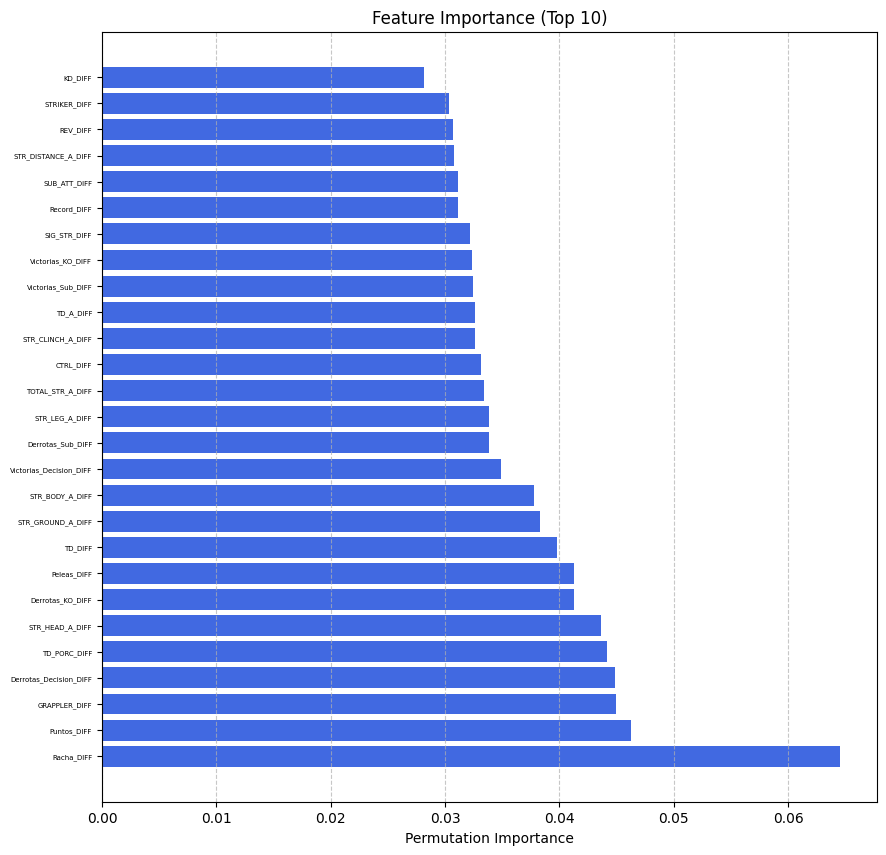

In [72]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### Conclusiones
Tras evaluar los resultados del modelo utilizando dos enfoques de ajuste de hiperparámetros, se concluye que Grid Search logra un rendimiento ligeramente superior a la simple predicción de la clase mayoritaria. Sin embargo, su accuracy sigue siendo inferior al del modelo XGBoost basado en medias ponderadas, lo que indica que la estrategia de diferencias de estadísticas no ha mejorado la capacidad predictiva del modelo.